# Simple DQN on Keras
The DQN Algorithm solves the issues related to the function approximations with Neural Networks:
* Bootstrap issue (Estimation with an estimation)
* Uncorrelate samples of experiences to facilitate Gradient Descent

![alt text](imgs/DQN.png "DQN")

<img src="imgs/dqn_algo.png" alt="Algorithm DQN" style="width: 600px;"/>

### Act Greedy
$\pi^*(s) = \arg\!\max_a \ Q^*(s, a)$

### Target Error
$\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))$

### References
* https://medium.com/mlreview/speeding-up-dqn-on-pytorch-solving-pong-in-30-minutes-81a1bd2dff55
* https://stackoverflow.com/questions/51960225/dqn-average-reward-decrease-after-training-for-a-period-of-time
* https://medium.freecodecamp.org/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682
* https://towardsdatascience.com/atari-reinforcement-learning-in-depth-part-1-ddqn-ceaa762a546f
* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* https://github.com/keras-rl/keras-rl
* https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
* https://stackoverflow.com/questions/17280575/pdb-ipdb-for-python-break-on-editable-condition
* https://davidhamann.de/2017/04/22/debugging-jupyter-notebooks/
* https://colab.research.google.com/gist/Tony607/7f55518ba7af13eb7e2e782b3b50a38b/tensorboard_in_notebooks.ipynb
* https://colab.research.google.com/github/tensorflow/examples/blob/master/community/en/tensorboard/tf_dev_summit_2019.ipynb

### Import Libraries

In [1]:
import gym
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

# Debug
import ipdb; 

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

## Plot function
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_durations(durations_t):
    plt.figure(2)
    plt.clf()    
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Total Rewards')
    plt.plot(durations_t)
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:        
        plt.plot(moving_average(durations_t,20))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/leonardo_a/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


### Define Hyperparameters

In [2]:
train_episodes = 600              # max number of episodes to learn from
gamma = 0.99                      # future reward discount

# Exploration parameters
explore_start = 1.0               # exploration probability at start (Pure exploratory)
explore_stop = 0.01               # minimum exploration probability
decay_rate = 0.0001               # exponential decay rate for exploration prob

# Network parameters
hidden_size = 16                  # number of units in each Q-network hidden layer
learning_rate = 0.001             # Q-network learning rate

# Memory parameters
memory_size = 10000               # memory capacity
batch_size = 32                   # experience mini-batch size
pretrain_length = batch_size*10   # number experiences to pretrain the memory

consecutive_win_threshold = 5     # Number of Consecutive wins before stop training (5) (50 to the end)
target_updates = 5

### Load Tensorboard Extensions
This plugin allows tensorboard to appear on the jupyter notebook

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard.notebook
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

### Fix Random Seeds
To make the experiment reproducible, we will fix the following random seeds:
* OpenAI Gym
* Numpy
* Tensorflow

In [4]:
env.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

### Define Q-Network

In [5]:
class QNetwork:
    def __init__(self, env, learning_rate=0.01, state_size=4,
                 hidden_size=10):
        action_size = env.action_space.n
        # state inputs to the Q-network
        self.model = Sequential()

        self.model.add(Dense(hidden_size, activation='relu',input_dim=state_size))
        self.model.add(Dense(hidden_size, activation='relu'))
        self.model.add(Dense(action_size, activation='linear'))

        self.optimizer = Adam(lr=learning_rate)#, decay=1e-6)
        
        # Compile the model (Create the Graph)
        self.model.compile(loss='mse', optimizer=self.optimizer)
    
    def __call__(self, state):
        # Reshape states (,4) --> [1,4]
        state = np.expand_dims(state, axis=0)
        # Get Q-values
        Q_values = self.model.predict(state)[0]
        # Act greedly
        action = np.argmax(Q_values)
        return action
    
    def q_values(self, state):
        # Reshape states (,4) --> [1,4]
        state = np.expand_dims(state, axis=0)
        # Get Q-values
        Q_values = self.model.predict(state)
        return Q_values
    
    def set_weights(self, weights):
        self.model.set_weights(weights)
    
    def get_weights(self):
        return self.model.get_weights()


# Initialize DQN Network
mainQ = QNetwork(env, hidden_size=hidden_size, learning_rate=learning_rate)
targetQ = QNetwork(env, hidden_size=hidden_size, learning_rate=learning_rate)
targetQ.set_weights(mainQ.get_weights()) 


### Memory Buffer

In [6]:
class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)
    
    def __len__(self):
        return len(self.buffer)

    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)),
                               size=batch_size,
                               replace=False)
        return [self.buffer[ii] for ii in idx]

memory = Memory(max_size=memory_size)

### Training

In [7]:
# Initialize the simulation
state = env.reset()
rewards_per_episode = []

step = 0
num_consecutive_win = 0

# For each episodes
for i_episode in range(1, train_episodes):
    total_reward = 0
    t = 0
    # Update the target network, copying all weights and biases in DQN
    if i_episode % target_updates == 0:
        targetQ.set_weights(mainQ.get_weights()) 
        
    done = False
    # Start new episode on the environment
    env.reset()      
    
    # Run an episode to the end
    while not done:
        step += 1
     
        # Epsilon Greedy Decay
        explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
        
        # Epsilon Greedy
        if explore_p > np.random.rand():
            # Make a random action
            action = env.action_space.sample()
        else:
            # Get action from Q-network
            action = mainQ(state)

        # Take action, get new state and reward
        next_state, reward, done, _ = env.step(action)        
        total_reward += reward

        # Episode finish
        if done:
            print('DONE! Episode: {}'.format(i_episode),
                  'Total reward: {}'.format(total_reward),
                  'Explore P: {:.4f}'.format(explore_p))
            
            rewards_per_episode.append(total_reward)
            
            # Early Stop
            if total_reward >= 199:
                num_consecutive_win += 1
                print('Win...')
            else:
                num_consecutive_win = 0                
            
            if num_consecutive_win > consecutive_win_threshold:                
                break

            # Add experience to memory
            memory.add((state, action, reward, next_state, done))      
        else:
            # Add experience to memory
            memory.add((state, action, reward, next_state, done))
            state = next_state

        # Check if we have enough samples on memory to sample
        # If we don't have keep gathering expriences
        if len(memory) >= batch_size:
            # Sample experience from Replay Memory
            minibatch = memory.sample(batch_size)
        else:
            # Keep populating replay memory
            print('Populating replay buffer')
            continue
        
        # Instantiate inputs (states) and targets         
        inputs = np.zeros((batch_size, np.prod(env.observation_space.shape)))
        targets = np.zeros((batch_size, env.action_space.n))
        
        
        # Iterate on the minibatch of samples from the replay memory
        for exp_idx, (state_b, action_b, reward_b, next_state_b, done_b) in enumerate(minibatch):
            #ipdb.set_trace()
            inputs[exp_idx] = np.expand_dims(state_b, axis=0)
            
            if done_b:
                # Mark target as immediate reward (If was last experience of some episode)
                target = reward_b
            else:
                # Calculate target as TD error
                target = reward_b + gamma * np.max(targetQ.q_values(next_state_b))
            
            targets[exp_idx] = targetQ.q_values(state_b)
            targets[exp_idx][action_b] = target
        
        # Update the model (In each episode end)
        mainQ.model.fit(inputs, targets, epochs=1, 
                        verbose=0, callbacks=[tf.keras.callbacks.TensorBoard(logs_base_dir + "/keras")])
    
    # Stop Earlier ...
    if num_consecutive_win > consecutive_win_threshold:
        print('Number of consecutive wins high, stop earlier...')
        break

Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
DONE! Episode: 1 Total reward: 13.0 Explore P: 0.9987
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
DONE! Episode: 2 Total reward: 22.0 Explore P: 0.9965
DONE! Episode: 3 Total reward: 20.0 Explore P: 0.9946
DONE! Episode: 4 Total reward: 22.0 Explore P: 0.9924
DONE! Epi

DONE! Episode: 136 Total reward: 58.0 Explore P: 0.7126
DONE! Episode: 137 Total reward: 25.0 Explore P: 0.7109
DONE! Episode: 138 Total reward: 41.0 Explore P: 0.7080
DONE! Episode: 139 Total reward: 37.0 Explore P: 0.7054
DONE! Episode: 140 Total reward: 24.0 Explore P: 0.7037
DONE! Episode: 141 Total reward: 47.0 Explore P: 0.7005
DONE! Episode: 142 Total reward: 34.0 Explore P: 0.6981
DONE! Episode: 143 Total reward: 36.0 Explore P: 0.6957
DONE! Episode: 144 Total reward: 46.0 Explore P: 0.6925
DONE! Episode: 145 Total reward: 50.0 Explore P: 0.6891
DONE! Episode: 146 Total reward: 12.0 Explore P: 0.6883
DONE! Episode: 147 Total reward: 28.0 Explore P: 0.6864
DONE! Episode: 148 Total reward: 70.0 Explore P: 0.6817
DONE! Episode: 149 Total reward: 77.0 Explore P: 0.6765
DONE! Episode: 150 Total reward: 28.0 Explore P: 0.6747
DONE! Episode: 151 Total reward: 57.0 Explore P: 0.6709
DONE! Episode: 152 Total reward: 23.0 Explore P: 0.6694
DONE! Episode: 153 Total reward: 27.0 Explore P:

DONE! Episode: 279 Total reward: 171.0 Explore P: 0.1344
DONE! Episode: 280 Total reward: 200.0 Explore P: 0.1319
Win...
DONE! Episode: 281 Total reward: 200.0 Explore P: 0.1295
Win...
DONE! Episode: 282 Total reward: 181.0 Explore P: 0.1273
DONE! Episode: 283 Total reward: 188.0 Explore P: 0.1252
DONE! Episode: 284 Total reward: 178.0 Explore P: 0.1231
DONE! Episode: 285 Total reward: 200.0 Explore P: 0.1209
Win...
DONE! Episode: 286 Total reward: 163.0 Explore P: 0.1191
DONE! Episode: 287 Total reward: 171.0 Explore P: 0.1172
DONE! Episode: 288 Total reward: 200.0 Explore P: 0.1151
Win...
DONE! Episode: 289 Total reward: 168.0 Explore P: 0.1134
DONE! Episode: 290 Total reward: 144.0 Explore P: 0.1119
DONE! Episode: 291 Total reward: 181.0 Explore P: 0.1101
DONE! Episode: 292 Total reward: 200.0 Explore P: 0.1081
Win...
DONE! Episode: 293 Total reward: 145.0 Explore P: 0.1067
DONE! Episode: 294 Total reward: 174.0 Explore P: 0.1050
DONE! Episode: 295 Total reward: 200.0 Explore P: 0.1

### Plot Total Rewards per Episode

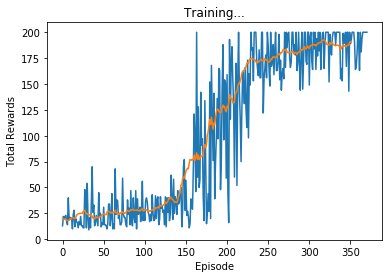

In [8]:
plot_durations(rewards_per_episode)

### Test trained Agent

In [9]:
# Reset environment
state = env.reset()
total_rewards = 0
while True:    
    # Act greedly
    action = mainQ(state)

    # Uncomment to render the visual state in a window
    env.render()

    # Step through environment using chosen action
    state, reward, done, _ = env.step(action)
    total_rewards += reward
    if done:
        break
print('Total Rewards:', total_rewards)

Total Rewards: 200.0
